# Projet 7 : Détecter les bads buzz grâce au Deep Learning - Air Paradis

- Problématique : Air Paradis a besoin de détecter les mauvais tweet afin de pouvoir agir rapidement.

Il faut ainsi développer un produit IA en utilisant 3 approches : 
- approche “API sur étagère” en utilisant l’API du service cognitif proposé par Microsoft Azure pour l’analyse de sentiment sur un échantillon des données
- approche “Modèle sur mesure simple” en utilisant le Concepteur / Designer d’un service Azure Machine Learning, interface graphique drag & drop, pour développer rapidement un modèle classique (ex : régression logistique) permettant de prédire le sentiment associé à un tweet.
- approche “Modèle sur mesure avancé” en utilisant le service Azure Machine Learning pour développer un modèle basé sur des réseaux de neurones profonds pour prédire le sentiment associé à un tweet qui sera présenté à Air Paradis

Les données utilisées sont des données opensource provenant de ce lien : https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+7%C2%A0-+D%C3%A9tectez+les+Bad+Buzz+gr%C3%A2ce+au+Deep+Learning/sentiment140.zip

Import des bibliothèques

In [50]:
import random
import os
# notre package de fonctionnalités
from Package import Scripts_Analyse01 as pk
from Package import Scripts_AnalyseMulti01 as pk_multi
from Package import Scripts_AnalyseMulti02_Unsupervised as pk_multi_unsp
from Package import Scripts_AnalyseMulti02_Supervised as pk_multi_sup
from IPython.core.display import display, HTML
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import pandas as pd
import numpy as np
import missingno
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from umap import UMAP
from scipy.stats import pearsonr
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from yellowbrick.features import ParallelCoordinates
from plotly.graph_objects import Layout
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.features import PCA as PCA_yellow
from yellowbrick.style import set_palette
from sklearn import metrics
from gensim.models.ldamodel import LdaModel
from  sklearn.feature_extraction.text  import CountVectorizer 
from sklearn.decomposition import SparsePCA
import gc
import time
from contextlib import contextmanager
from sklearn import cluster
import warnings
from dotenv import load_dotenv
import re
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from wordcloud import WordCloud
from unidecode import unidecode
from sklearn import metrics
from sklearn import manifold, decomposition
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from nltk.stem.snowball import SnowballStemmer
from spacy.language import Language
import spacy
from spacymoji import Emoji
warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext pycodestyle_magic


The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [51]:
from tqdm import tqdm,notebook
notebook.tqdm().pandas()

0it [00:01, ?it/s]

In [52]:
load_dotenv()

Python-dotenv could not parse statement starting at line 1


True

## Collecte des données

### Import des données

In [4]:
df = pd.read_csv('input/base.csv', encoding='latin-1', header=None)

In [5]:
df.shape

(1600000, 6)

In [ ]:
##########GRAPH TARGET

In [1]:
########### wordcloud par classe

In [6]:
df = df.sample(100)

In [7]:
df.head(2)

,0,1,2,3,4,5
1515932,4,2175658611,Mon Jun 15 01:37:08 PDT 2009,NO_QUERY,yanti29,@missrain kenapa bu? apanya yang complicated? ...
1306183,4,2011567947,Tue Jun 02 19:13:22 PDT 2009,NO_QUERY,marshaambrosius,@kingbritt I love my dentist hope all is well...


In [8]:
df = df.drop([3], axis=1)

In [9]:
df.head(2)

,0,1,2,4,5
1515932,4,2175658611,Mon Jun 15 01:37:08 PDT 2009,yanti29,@missrain kenapa bu? apanya yang complicated? ...
1306183,4,2011567947,Tue Jun 02 19:13:22 PDT 2009,marshaambrosius,@kingbritt I love my dentist hope all is well...


In [10]:
df.columns = ["target", "identity", "date", "username", "tweet"]

In [11]:
df.head(2)

,target,identity,date,username,tweet
1515932,4,2175658611,Mon Jun 15 01:37:08 PDT 2009,yanti29,@missrain kenapa bu? apanya yang complicated? ...
1306183,4,2011567947,Tue Jun 02 19:13:22 PDT 2009,marshaambrosius,@kingbritt I love my dentist hope all is well...


### Export csv

In [68]:
df.to_csv("output/sample.csv")

In [16]:
df = pd.read_csv("output/sample.csv")

In [17]:
del df["Unnamed: 0"]

## Construction de la base de données

## Pré-traitement des données

Vérification des doublons

In [14]:
sum(df.duplicated())

0

In [15]:
df.head(2)

,target,identity,date,username,tweet
0,0,2066896734,Sun Jun 07 11:22:24 PDT 2009,urfavnerd,Horrible cough people gave me mean looks @ th...
1,0,2068940106,Sun Jun 07 14:58:47 PDT 2009,pmachenbach,i burnt my tounge


Vérification des données manquantes

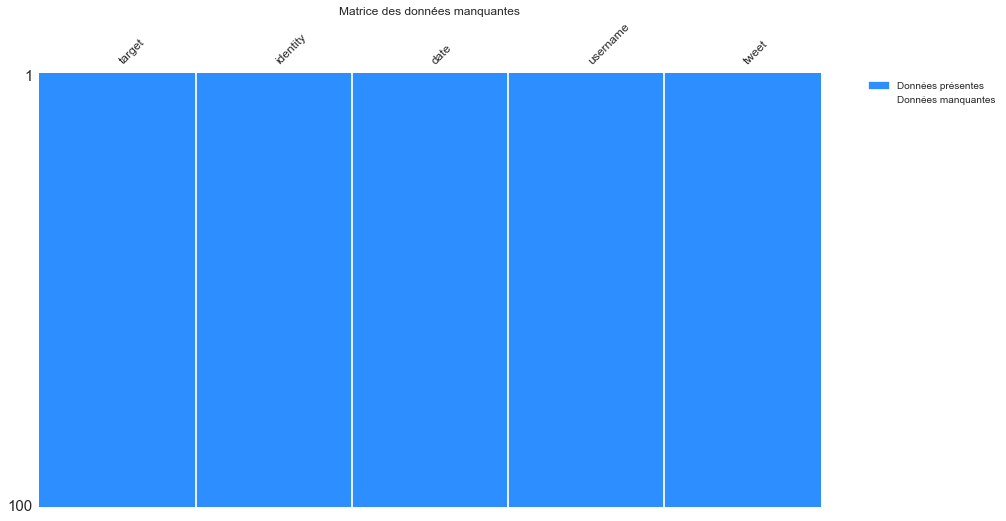

In [16]:
pk.matrix_vm(df, (14,8), (0.18, 0.56, 1))

Aucune donnée manquante

Passons au traitement du texte

In [17]:
df.head(2)

,target,identity,date,username,tweet
0,0,2066896734,Sun Jun 07 11:22:24 PDT 2009,urfavnerd,Horrible cough people gave me mean looks @ th...
1,0,2068940106,Sun Jun 07 14:58:47 PDT 2009,pmachenbach,i burnt my tounge


Regardons le nombre de texte en fonction de la variable "TARGET"  qui représente la polarité du tweet (0 = negative, 2 = neutral et 4 = positive)

Avant créons une variable avec les libellées pour améliorer la lisibilité

In [18]:
def lib_polarite_target(target):
    if target == 0:
        return "Negative"
    elif target == 2:
        return "Neutral"
    elif target == 4:
        return "Positive"

df["target_lib"] = df["target"].progress_apply(lambda x: lib_polarite_target(x))

  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
df.head(5)

,target,identity,date,username,tweet,target_lib
0,0,2066896734,Sun Jun 07 11:22:24 PDT 2009,urfavnerd,Horrible cough people gave me mean looks @ th...,Negative
1,0,2068940106,Sun Jun 07 14:58:47 PDT 2009,pmachenbach,i burnt my tounge,Negative
2,0,2326228644,Thu Jun 25 06:44:32 PDT 2009,rewardme,"@candice216 aww, i sorry Hope it improves Q...",Negative
3,4,1962748752,Fri May 29 11:35:21 PDT 2009,Darlene_Mae,http://twitpic.com/674el - &quot;Mayhem&quot; ...,Positive
4,0,1989795626,Mon Jun 01 02:50:17 PDT 2009,luanapalma,"Byye, now I gotta go hehe",Negative


Etudions notre variable

In [27]:
def graph_circle(data, column, title):
    """
    Graphique circulaire
    Args:
        data ([type]): données de la colonne à representer
        column ([type]): nom de la colonne
        title ([type]): titre du graphique
    Exemple:
    graph_circle(data["libelle_francais"], "libelle_francais",
                 "Répartition des arbres en fonction de leur appellation")
    """
    t = pd.crosstab(data, "freq", normalize=True)
    t = t.assign(column=t.index, freq=100 * t.freq)
    plt.figure(figsize=(18, 8))
    plt.pie(t.freq, labels=t.column,  autopct='%.0f%%')

    plt.title(title)
    my_circle = plt.Circle((0, 0), 0.4, color='white')
    p = plt.gcf()
    p.gca().add_artist(my_circle)

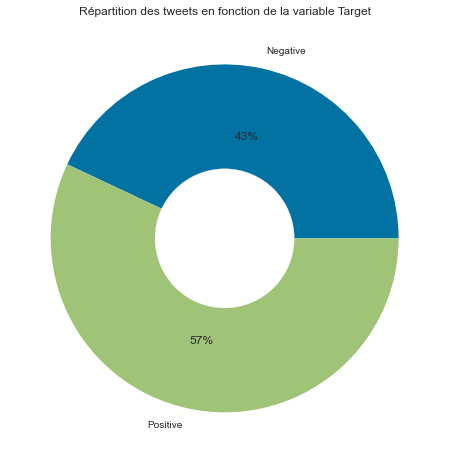

In [29]:
graph_circle(df["target_lib"], "Target",
                 "Répartition des tweets en fonction de la variable Target")

Nous observons que notre variable cible est à peu près équilibrée. En effet, nous retrouvons 57% de tweets avec un sentiment positif, contre 43% avec un sentiment negatif.

Traçons un wordcloud par classe même si le texte n'est pas encore nettoyé

### Passons au nettoyage et à l'analyse de la variable "tweet"

In [30]:
df.head(2)

,target,identity,date,username,tweet,target_lib
0,0,2066896734,Sun Jun 07 11:22:24 PDT 2009,urfavnerd,Horrible cough people gave me mean looks @ th...,Negative
1,0,2068940106,Sun Jun 07 14:58:47 PDT 2009,pmachenbach,i burnt my tounge,Negative


In [32]:
df["tweet"][0]

'Horrible cough  people gave me mean looks @ the movies and church'

Nous observons que des tweets mélangent majuscule et minuscule. Nous allons donc mettre le texte en minuscule. Notons aussi que nous observons un @. Il faudra donc supprimer la ponctuation.

Pour cela, nous allons utiliser spacy. Et créer un pipeline que nous complèterons au fur et à mesure afin d'avoir un texte nettoyé.
Nous mettrons donc par la suite notre texte en minuscule et nous supprimerons la ponctuation.

Nous savons que dans les tweets, nous pouvons trouver : 
- des emoticônes et des emojicônes
- des mentions (ex : @toto)
- des hashtags (ex #toureiffel)
- des reponses directes à d'autres tweets, qui seront notées avec "RE"
- des emails
- des urls

En conséquence, nous devons retranscrire les emojicônes/emoticônes car ils expriments un sentiment. 
Et il nous faut supprimer les autres éléments qui n'apportent pas forcément d'informations sur le sentiment du tweet, excepté pour les hashtags qui peuvent exprimer des sentiments tel que #encolere

Commençons par ajouter au pipeline l'identification des emoticônes et des emojicônes en premier

Pour rappel, dans le pipeline de spacy nous avons !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [216]:
nlp = spacy.load("en_core_web_sm")
_ = nlp.add_pipe("emoji", first=True)

In [217]:
nlp.pipe_names

['emoji',
 'tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner']

In [218]:
gc.collect()

10638

Nous avons bien ajouté emoji en premier. Vérifions que cela fonctionne avec un texte

In [219]:
doc = nlp("Dr. Alex Smith :-) 😂 chaired LMAO first board meeting of Acme Corp Inc. titi@gmail.com <https://t.co> Re")
print([(token.text, token._.is_emoji) for token in doc])

[('Dr.', False), ('Alex', False), ('Smith', False), (':-)', False), ('😂', True), ('chaired', False), ('LMAO', False), ('first', False), ('board', False), ('meeting', False), ('of', False), ('Acme', False), ('Corp', False), ('Inc.', False), ('titi@gmail.com', False), ('<', False), ('https://t.co', False), ('>', False), ('Re', False)]


Notre emojicône est bien détectée contrairement à l'emoticône. Il nous faudra donc ajouter une autre méthode.
Vérifions si nous pouvons détecter les url, les e-mails et la ponctuation.

!!!!!!!!!!!!!!!!!!!! problem ROFL | LOL | LMAO + :) :(

In [220]:
print([(token.text,token.is_punct, token._.is_emoji, token._.emoji_desc, token.like_email, token.is_stop) for token in doc])

[('Dr.', False, False, None, False, False), ('Alex', False, False, None, False, False), ('Smith', False, False, None, False, False), (':-)', True, False, None, False, False), ('😂', False, True, 'face with tears of joy', False, False), ('chaired', False, False, None, False, False), ('LMAO', False, False, None, False, False), ('first', False, False, None, False, True), ('board', False, False, None, False, False), ('meeting', False, False, None, False, False), ('of', False, False, None, False, True), ('Acme', False, False, None, False, False), ('Corp', False, False, None, False, False), ('Inc.', False, False, None, False, False), ('titi@gmail.com', False, False, None, True, False), ('<', False, False, None, False, False), ('https://t.co', False, False, None, False, False), ('>', False, False, None, False, False), ('Re', False, False, None, False, True)]


Nous détectons bien ces informations.

Ajoutons "RE" dans les stopwords qui apparait lors de la réponse direct à un tweet

Voici un extrait de la liste des stopwords.

In [221]:
#Printing first ten stop words:
print('First ten stop words: ', print(nlp.Defaults.stop_words))

{'fifty', 'not', 'after', 'as', 'would', 'across', 'too', 'indeed', 'anything', 'she', 'least', 'unless', 'when', 'whence', 'herein', '’s', '’d', 'anywhere', 'nine', 'himself', 'hundred', 'hereupon', 'somewhere', 'within', 'therein', 'whereby', 'others', 'somehow', 'whether', 'whenever', 'next', 'nothing', 'which', 'thru', 'nowhere', '‘ll', 'by', 'first', 'yourselves', 'only', 'almost', 'call', 'ourselves', 'her', 'any', 'already', 'him', 'much', 'neither', 'noone', 'who', 'hereafter', 'hers', '‘m', 'hence', 'along', 'thereby', 'another', 'sometimes', 'a', 'side', 'us', 'could', 'ever', "'s", 'if', 'own', 'whither', 'will', 'me', 'become', 'becomes', 'part', 'something', 'always', 'are', 'even', 'off', 'beside', 'toward', 'although', 'everyone', 'more', 'it', 'still', 'get', "'ll", 'no', 'just', 'done', 'under', 'before', 'namely', 'up', '‘s', 'from', 'n‘t', 'other', 'may', 'whole', 'he', 'do', 'and', 'to', 'three', 'its', 'eleven', 'latterly', 'anyway', 'can', 'yourself', 'keep', 'mor

Ajoutons "RE"

In [222]:
nlp.Defaults.stop_words.add("re")

In [223]:
print([(token.text,token.is_punct, token._.is_emoji, token._.emoji_desc, token.like_email, token.is_stop) for token in doc])

[('Dr.', False, False, None, False, False), ('Alex', False, False, None, False, False), ('Smith', False, False, None, False, False), (':-)', True, False, None, False, False), ('😂', False, True, 'face with tears of joy', False, False), ('chaired', False, False, None, False, False), ('LMAO', False, False, None, False, False), ('first', False, False, None, False, True), ('board', False, False, None, False, False), ('meeting', False, False, None, False, False), ('of', False, False, None, False, True), ('Acme', False, False, None, False, False), ('Corp', False, False, None, False, False), ('Inc.', False, False, None, False, False), ('titi@gmail.com', False, False, None, True, False), ('<', False, False, None, False, False), ('https://t.co', False, False, None, False, False), ('>', False, False, None, False, False), ('Re', False, False, None, False, True)]


"Re" est donc bien détecté comme un stopword.

Créons une fonction pour détecter les mentions dans les tweets (ex: @toto)

In [224]:
from spacy.tokens import Token

# Définit l'extension sur le Token avec une valeur par défaut
#Token.set_extension("is_mention", default=False)

def is_mention_function(token):
    if token.text.startswith("@") == True and len(token.text)>1:
        return True
        
Token.set_extension("is_mention", getter=is_mention_function, force=True)

In [225]:
doc = nlp("I have @toto")
for token in doc:
    if token._.is_mention == True:
        print(token._.is_mention)

True


La mention est bien détectée

Nous pouvons donc créer un nouveau composant qui permettra d'obtenir nos mots nettoyés

In [226]:
# Définit un composant personnalisé
def text_clean_function(doc):
    new_words = []
    for token in doc:
        if token._.is_emoji:
            if token._.emoji_desc != " ":
                new_words.append(token._.emoji_desc)
            else:
                continue
        elif token.like_email or token.is_stop or token.like_url:
            continue
        elif token._.is_mention == True:
            continue
        elif token.is_punct:
            continue
        else :
            if token.text.strip() != "":
                new_words.append(token.text)
    return new_words


In [227]:
from spacy.tokens import Doc

@Language.component("pre_process_text")
def pre_process_text_function(doc):
    # Generate a new list of tokens here
    new_words = text_clean_function(doc)
    new_doc = Doc(doc.vocab, words=new_words)
    return new_doc

In [228]:
# Ajoute le composant en premier dans le pipeline
nlp.add_pipe("pre_process_text", before="tok2vec")

<function __main__.pre_process_text_function(doc)>

In [229]:
doc = nlp("Dr. Alex Smith :-) 😂 @toto chaired LMAO first board meeting of Acme Corp Inc. titi@gmail.com <https://t.co> Re")


In [211]:
def stemming_function(doc):
    stemmer = SnowballStemmer(language='english')
    list_doc = []
    for token in doc:
        print(token.text)
        list_doc.append(stemmer.stem(token.text))
    return list_doc

In [230]:
test = stemming_function(doc)

In [232]:
doc.text

'Dr. Alex Smith face with tears of joy chaired LMAO board meeting Acme Corp Inc. < > '

In [231]:
test

['dr.',
 'alex',
 'smith',
 'face with tears of joy',
 'chair',
 'lmao',
 'board',
 'meet',
 'acm',
 'corp',
 'inc.',
 '<',
 '>']

In [277]:
from spacy.tokens import Token

# Définit l'extension sur le Token avec une valeur par défaut
#Token.set_extension("is_mention", default=False)
def stemming_function(token):
    stemmer = SnowballStemmer(language='english')
    stem = stemmer.stem(token.text)
    return stem

Token.set_extension("stemming_", getter=stemming_function, force=True)

In [274]:
doc = nlp("Dr. Alex Smith :-) 😂 @toto chaired LMAO first board meeting of Acme Corp Inc. titi@gmail.com <https://t.co> Re")


In [279]:
for token in doc:
    print(token._.stemming_)

dr.
alex
smith
face with tears of joy
chair
lmao
board
meet
acm
corp
inc.
<
>


In [187]:
df["tweet_clean"] = df["tweet"].progress_apply(lambda x: nlp(x))

  0%|          | 0/100 [00:00<?, ?it/s]

In [188]:
df["tweet_lemma"] = df["tweet"].progress_apply(lambda x: [token.lemma_ for token in nlp(x)])

  0%|          | 0/100 [00:00<?, ?it/s]

In [280]:
df["tweet_stem"] = df["tweet"].progress_apply(lambda x: [token._.stemming_ for token in nlp(x)])

  0%|          | 0/100 [00:00<?, ?it/s]

In [281]:
df.head(2)

,target,identity,date,username,tweet,target_lib,tweet_clean,tweet_lemma,tweet_stem
0,0,2066896734,Sun Jun 07 11:22:24 PDT 2009,urfavnerd,Horrible cough people gave me mean looks @ th...,Negative,"(Horrible, cough, people, gave, mean, looks, m...","[horrible, cough, people, give, mean, look, mo...","[horribl, cough, peopl, gave, mean, look, movi..."
1,0,2068940106,Sun Jun 07 14:58:47 PDT 2009,pmachenbach,i burnt my tounge,Negative,"(burnt, tounge)","[burn, tounge]","[burnt, toung]"


Nous ne supprimons pas les # car on peut avoir des #encolere

In [169]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)


pattern =  [{'ORTH': '#'}, {'IS_ASCII': True}]
matcher.add('HASHTAG', [pattern])

doc = nlp("Hello, world! Hello world! ###toto")
matches = matcher(doc)
for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    span = doc[start:end]  # The matched span
    print( string_id, start, end, span.text)

    

True


In [183]:
df.head(3)

,target,identity,date,username,tweet,target_lib,tweet_clean,tweet_lemma
0,0,2066896734,Sun Jun 07 11:22:24 PDT 2009,urfavnerd,Horrible cough people gave me mean looks @ th...,Negative,"(Horrible, cough, people, gave, mean, looks, m...","[horrible, cough, people, give, mean, look, mo..."
1,0,2068940106,Sun Jun 07 14:58:47 PDT 2009,pmachenbach,i burnt my tounge,Negative,"(burnt, tounge)","[burn, tounge]"
2,0,2326228644,Thu Jun 25 06:44:32 PDT 2009,rewardme,"@candice216 aww, i sorry Hope it improves Q...",Negative,"(aww, sorry, Hope, improves, QUICK)","[@candice216, aww, sorry, Hope, improve, QUICK]"


In [282]:
gc.collect()

9912

#### !!!!!!!!!!!!retraçons les wordcloud par classe et par methode stem / lemma

## Feature engineering

Deux méthodes : Glove, Fasttext

### Commençons par Glove

C'est un réseau de neurone qui permet de détecter des mots synonymes et  de suggérer des mots supplémentaires pour des phrases partielles une fois qu'il est formé.

In [67]:
pk.wordcloud_plot(str(all_tweets))

AttributeError: 'str' object has no attribute 'str'

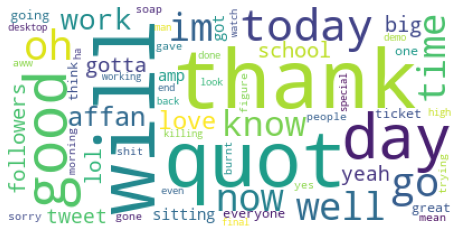

In [69]:
    #all_reviews = data.str.cat(sep=' ')
    wordcloud = WordCloud(background_color = 'white', max_words = 60).generate(str(all_tweets))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [ ]:
word2vec / tf-idf / bag of word / Glove / fasttext ajouter >> spacy

### Passons à Fasttext

## Service cognitif Azure : Analyse de sentiment

In [5]:
#################key vault

cog_key = os.getenv('cog_key')
cog_endpoint = os.getenv('cog_endpoint')

#print('Ready to use cognitive services at {} using key {}'.format(cog_endpoint, cog_key))


In [6]:
import os
from azure.ai.textanalytics import TextAnalyticsClient

from azure.cognitiveservices.language.textanalytics import TextAnalyticsClient
from msrest.authentication import CognitiveServicesCredentials

# Get a client for your text analytics cognitive service resource
text_analytics_client = TextAnalyticsClient(endpoint=cog_endpoint,
                                            credentials=CognitiveServicesCredentials(cog_key))


In [9]:
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

# Authenticate the client using your key and endpoint 
def authenticate_client():
    ta_credential = AzureKeyCredential(cog_key)
    text_analytics_client = TextAnalyticsClient(
            endpoint=cog_endpoint, 
            credential=ta_credential)
    return text_analytics_client

client = authenticate_client()

In [10]:
documents = ["I had the best day of my life. I wish you were there with me."]
response = client.analyze_sentiment(documents=documents)[0]
print("Document Sentiment: {}".format(response.sentiment))
print("Overall scores: positive={0:.2f}; neutral={1:.2f}; negative={2:.2f} \n".format(
        response.confidence_scores.positive,
        response.confidence_scores.neutral,
        response.confidence_scores.negative,
    ))


Document Sentiment: positive
Overall scores: positive=0.99; neutral=0.00; negative=0.00 



## Part 2